## Chat with your PDF files using LlamaIndex, Astra DB (Apache Cassandra), and Gradient's open-source models, including LLama2 and Streamlit, all designed for seamless interaction with PDF files.


# Installation

In [1]:
!pip install -q cassandra-driver
!pip install -q cassio>=0.1.1
!pip install -q gradientai --upgrade
!pip install -q llama-index
!pip install -q pypdf
!pip install -q tiktoken==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.1/171.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

# Import OS & JSON Modules

In [2]:
import os
import json
from google.colab import userdata

os.environ['GRADIENT_ACCESS_TOKEN'] = 'xxx'
os.environ['GRADIENT_WORKSPACE_ID'] =  'xxxxx-'

# Import Cassandra & llama Index

In [3]:
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster
from llama_index import ServiceContext
from llama_index import set_global_service_context
from llama_index import VectorStoreIndex, SimpleDirectoryReader, StorageContext
from llama_index.embeddings import GradientEmbedding
from llama_index.llms import GradientBaseModelLLM
from llama_index.vector_stores import CassandraVectorStore

In [4]:
import cassandra
print (cassandra.__version__)

3.29.0


# Connect to the VectorDB

In [6]:
# This secure connect bundle is autogenerated when you donwload your SCB,
# if yours is different update the file name below
cloud_config= {
  'secure_connect_bundle': '/content/secure-connect-db-pdf.zip'
}

# This token json file is autogenerated when you donwload your token,
# if yours is different update the file name below
with open("/content/db_pdf-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(131957832381488) 00bca116-fb3e-44f7-b8bf-2d0c6fa01e28-us-east1.db.astra.datastax.com:29042:01bec412-40f1-4235-bb24-5e11b2020c3a> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


4.0.11-c7d4aa9d7ae5


# Define the Gradient's Model Adapter for LLAMA-2

In [7]:
llm = GradientBaseModelLLM(
    base_model_slug="llama2-7b-chat",
    max_tokens=400,
)

# Configure Gradient embeddings

In [8]:
embed_model = GradientEmbedding(
    gradient_access_token = os.environ["GRADIENT_ACCESS_TOKEN"],
    gradient_workspace_id = os.environ["GRADIENT_WORKSPACE_ID"],
    gradient_model_slug="bge-large",
)

In [9]:
service_context = ServiceContext.from_defaults(
    llm = llm,
    embed_model = embed_model,
    chunk_size=256,
)

set_global_service_context(service_context)

# Load the PDFs

In [10]:
documents = SimpleDirectoryReader("/content/Documents").load_data()
print(f"Loaded {len(documents)} document(s).")

Loaded 17 document(s).


# Setup and Query Index

In [11]:
index = VectorStoreIndex.from_documents(documents,
                                        service_context=service_context)
query_engine = index.as_query_engine()

# Questions on apache-cassandra-whitepaper.pdf

In [12]:
response = query_engine.query("What is Cassandra?")
print(response)

 Cassandra is a distributed storage system for managing very large amounts of structured data spread out across many commodity servers, while providing highly available service with no single point of failure.


In [13]:
response = query_engine.query("How does facebook use Cassandra?")
print(response)

 According to the text, Facebook uses Cassandra as the backend storage system for multiple services within the platform. Specifically, Inbox Search was launched in June of 2008 for around 100 million users and today they are at over 250 million users, and Cassandra has kept up the promise so far.


# Questions on Attention Paper

In [14]:
response = query_engine.query("What is Multi Head Attention?")
print(response)

 Multi-Head Attention is a type of attention mechanism used in the Transformer architecture, where the input is split into multiple attention heads, each with their own set of learnable parameters. Each head computes its own attention weights and processes the input independently. The outputs of all heads are then concatenated and linearly transformed to produce the final output. The key advantage of Multi-Head Attention is that it allows the model to focus on different aspects of the input sequence simultaneously, improving the overall performance of the model.


In [15]:
response = query_engine.query("What is Positional Encoding?")
print(response)

 Positional encoding is a technique used in attention-based models to provide the model with information about the position of an element in a sequence. In this work, we use sine and cosine functions of different frequencies to create positional encodings. The positional encodings are added to the embeddings to create the final input to the model.


# streamlit Application

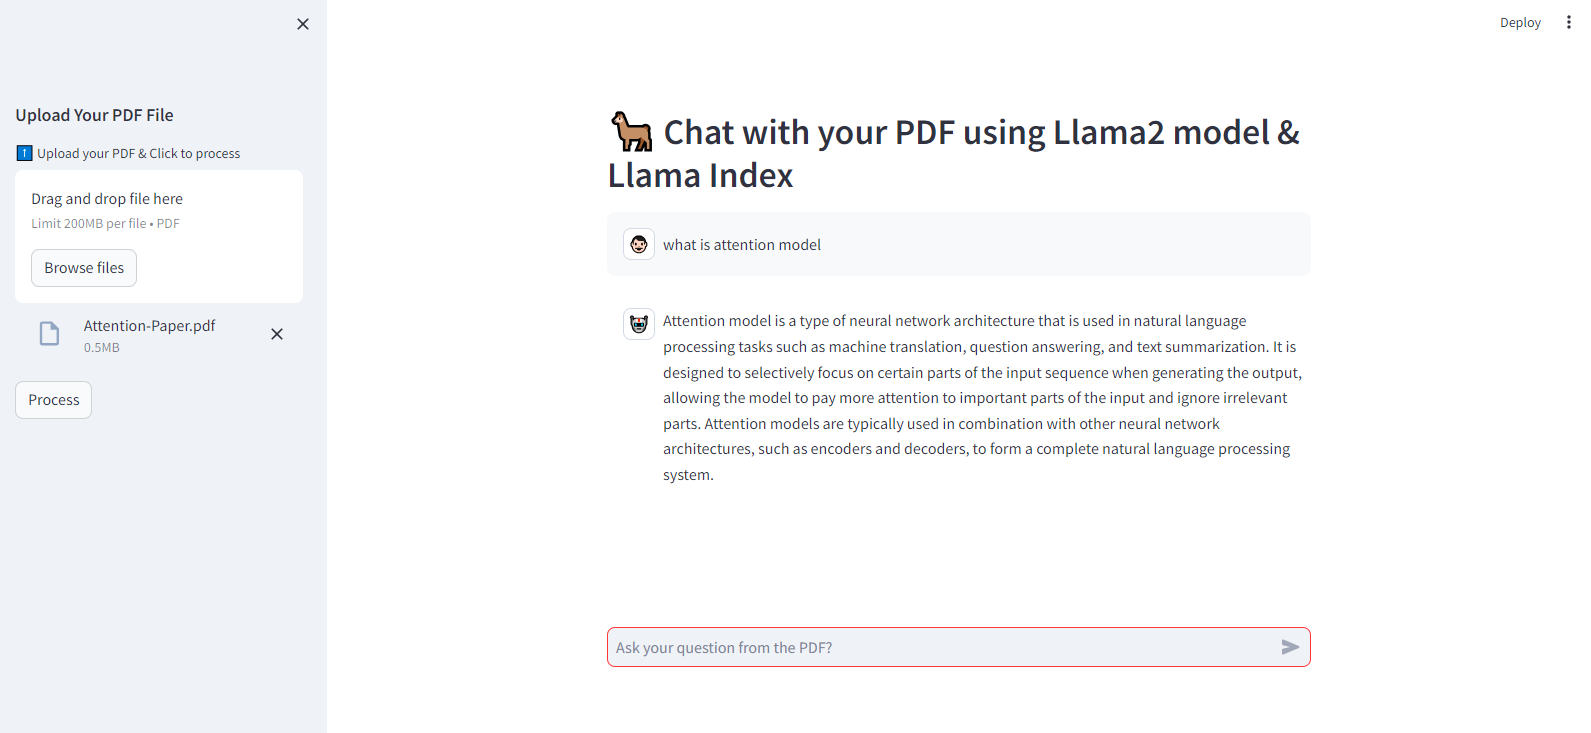